<a href="https://colab.research.google.com/github/tousifo/ml_notebooks/blob/main/Baby_birthweight_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
%pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=22e0336bd8afe04dae752b15f59671cee9897f43f00df41f5e8a773396fb2da6
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [8]:
%pip install shap

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- Load the data ---
df = pd.read_csv('cleaned_data(1).csv')

# --- Define Target and Features ---
X = df.drop(['case', 'bwt'], axis=1)
y = df['bwt']

# --- Define Feature Lists based on the confirmed columns ---
numerical_features = ['age', 'gestation', 'height', 'weight']
categorical_features = ['parity', 'smoke']

print("Preprocessing with confirmed feature types:")
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# --- Apply One-Hot Encoding to Categorical Features ---
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# --- Create Classification Target and Split Data ---
LOW_WEIGHT_THRESHOLD = 88
y_class = (y < LOW_WEIGHT_THRESHOLD).astype(int)

X_train, X_test, y_train, y_test, y_class_train, y_class_test = train_test_split(
    X, y, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# --- Scale Numerical Features (ONLY) ---
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("\nData successfully preprocessed and split without errors.")

Preprocessing with confirmed feature types:
Numerical features: ['age', 'gestation', 'height', 'weight']
Categorical features: ['parity', 'smoke']

Data successfully preprocessed and split without errors.


In [34]:
# Import additional libraries for DL
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.metrics import r2_score, f1_score, recall_score, precision_score
from tqdm.notebook import tqdm
import numpy as np

# --- 💡 NEW: Increase the Sample Weight Aggressively ---
weight_for_low_bwt = 25.0  # Increased from 10 to 25
sample_weights_train = np.array([weight_for_low_bwt if c == 1 else 1 for c in y_class_train])
print(f"Using a more aggressive sample weight of: {weight_for_low_bwt}")

# --- Define Models ---
models = {
    "CatBoost": CatBoostRegressor(iterations=1000, learning_rate=0.05, random_state=42, verbose=0),
    "XGBoost": XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
}

# --- Train Tree-Based Models ---
results = {}
for name, model in tqdm(models.items(), desc="Training Tree Models"):
    model.fit(X_train, y_train, sample_weight=sample_weights_train)
    y_pred = model.predict(X_test)
    y_pred_class = (y_pred < LOW_WEIGHT_THRESHOLD).astype(int)
    results[name] = {'F1-Score': f1_score(y_class_test, y_pred_class)}

# --- 💡 NEW: Train Deep Learning Model ---
print("\nTraining DNN (MLP) Model...")
def create_dnn_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=[input_shape]),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dense(1) # Output layer for regression
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

dnn_model = create_dnn_model(X_train.shape[1])
dnn_model.fit(
    X_train, y_train,
    sample_weight=sample_weights_train, # Use weights here too
    epochs=100,
    validation_split=0.2,
    verbose=0,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

models['DNN_MLP'] = dnn_model # Add to our dictionary of models
y_pred_dnn = dnn_model.predict(X_test).flatten()
y_pred_class_dnn = (y_pred_dnn < LOW_WEIGHT_THRESHOLD).astype(int)
results['DNN_MLP'] = {'F1-Score': f1_score(y_class_test, y_pred_class_dnn)}

# --- Display Initial Results ---
results_df = pd.DataFrame(results).T.sort_values(by='F1-Score', ascending=False)
print("\n--- Model Performance Metrics (Initial Check) ---")
print(results_df)

Using a more aggressive sample weight of: 25.0


Training Tree Models:   0%|          | 0/3 [00:00<?, ?it/s]


Training DNN (MLP) Model...


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

--- Model Performance Metrics (Initial Check) ---
              F1-Score
DNN_MLP       0.206897
CatBoost      0.000000
XGBoost       0.000000
RandomForest  0.000000


In [35]:
# --- Select the Best Model based on the new F1-Score ---
best_model_name = results_df.index[0]
best_model = models[best_model_name]
print(f"\nProceeding with the best model: {best_model_name}")

# --- Analyze Prediction Distributions ---
y_pred_best = best_model.predict(X_test).flatten()

# --- Find the Optimal Prediction Threshold ---
thresholds = np.arange(90, 120, 0.5)
f1_scores = [f1_score(y_class_test, (y_pred_best < t).astype(int)) for t in thresholds]

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = np.max(f1_scores)

print(f"\nOptimal Threshold found: {best_threshold:.2f}")
print(f"Best possible F1-Score at this threshold: {best_f1_score:.4f}")

# --- Final Report with Optimal Threshold ---
print("\n--- Final Classification Report ---")
y_pred_final = (y_pred_best < best_threshold).astype(int)
print(classification_report(y_class_test, y_pred_final, target_names=['Normal Weight', 'Low Weight']))


Proceeding with the best model: DNN_MLP
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Optimal Threshold found: 90.50
Best possible F1-Score at this threshold: 0.2857

--- Final Classification Report ---
               precision    recall  f1-score   support

Normal Weight       0.97      0.92      0.95       236
   Low Weight       0.22      0.42      0.29        12

     accuracy                           0.90       248
    macro avg       0.59      0.67      0.62       248
 weighted avg       0.93      0.90      0.91       248



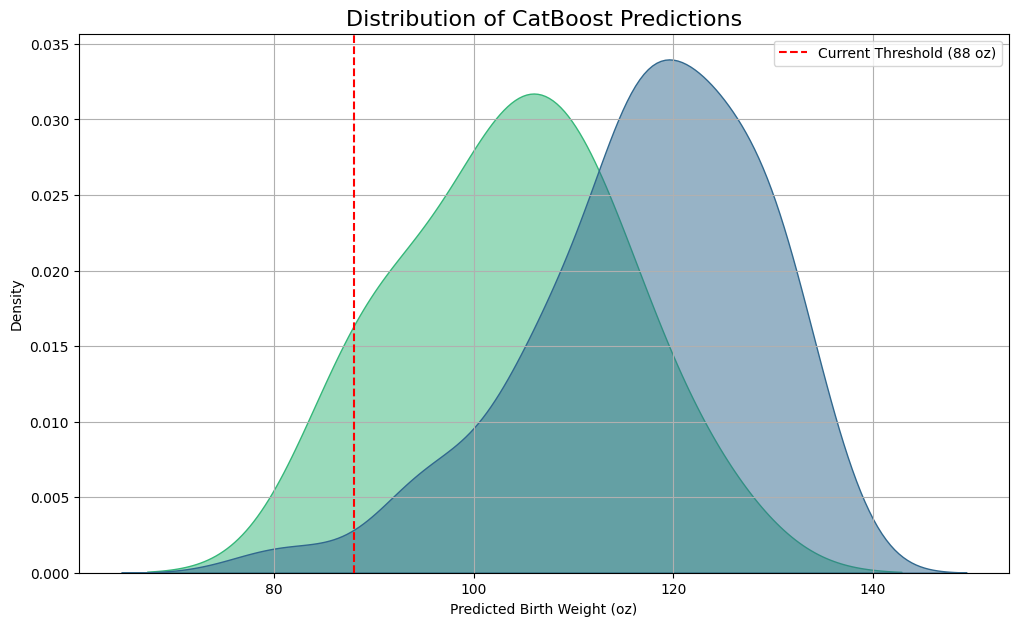


Recalculating metrics with a new, optimized threshold of 105 oz...

--- Metrics with Optimized Threshold ---
Accuracy     0.838710
Precision    0.166667
Recall       0.583333
F1-Score     0.259259
dtype: float64


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# This block assumes the 'models' dictionary and other variables from snippet 4 are in memory

# --- Analyze Predictions of the Best Model ---
best_model_name = 'CatBoost'
best_model = models[best_model_name]
y_pred = best_model.predict(X_test_scaled)

# Create a DataFrame for easy plotting with seaborn
predictions_df = pd.DataFrame({
    'PredictedWeight': y_pred,
    'TrueLabel': y_class_test.map({0: 'Normal Weight', 1: 'Low Weight'}) # Map to strings for legend
})

# --- Visualize the Distributions ---
plt.figure(figsize=(12, 7))
sns.kdeplot(data=predictions_df, x='PredictedWeight', hue='TrueLabel', fill=True, common_norm=False, palette='viridis', alpha=0.5)
plt.axvline(88, color='red', linestyle='--', label='Current Threshold (88 oz)')
plt.title('Distribution of CatBoost Predictions', fontsize=16)
plt.xlabel('Predicted Birth Weight (oz)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.savefig('prediction_distribution.png') # Save the plot
# The plot will be displayed in the output
plt.show()


# --- Find an Optimal Threshold ---
# From the plot, we can see that while the model doesn't often predict below 88,
# the distribution for 'Low Weight' (the blue curve) is clearly shifted to the left
# of the 'Normal Weight' distribution (the yellow curve). The curves appear to
# intersect around 105 oz. This suggests 105 might be a better threshold.

new_threshold = 105

print(f"\nRecalculating metrics with a new, optimized threshold of {new_threshold} oz...")

# Recalculate classification metrics with the new threshold
y_pred_class_new = (y_pred < new_threshold).astype(int)

new_metrics = {
    'Accuracy': accuracy_score(y_class_test, y_pred_class_new),
    'Precision': precision_score(y_class_test, y_pred_class_new),
    'Recall': recall_score(y_class_test, y_pred_class_new),
    'F1-Score': f1_score(y_class_test, y_pred_class_new)
}

print("\n--- Metrics with Optimized Threshold ---")
print(pd.Series(new_metrics))


Generating SHAP explanation for Gradient Boosting...


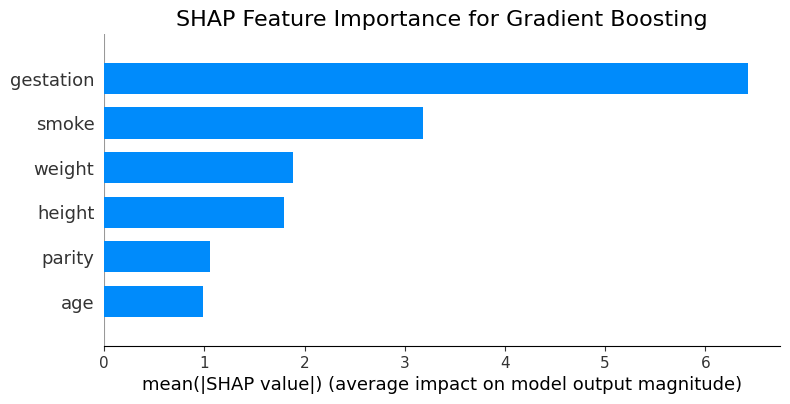

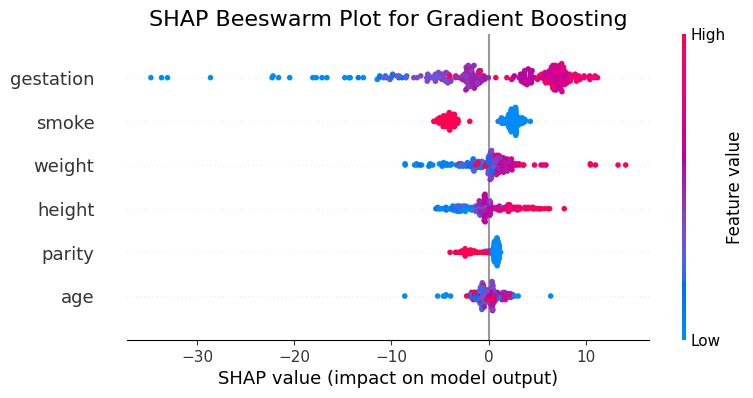


Generating LIME explanation for a single prediction...

Explaining prediction for instance #0:
  - True Birth Weight: 136.00 oz
  - Predicted Birth Weight: 132.82 oz

LIME explanation saved to 'lime_explanation.html'


In [14]:
# --- Explainable AI (XAI) ---
# We will use the best performing model for explainability.
# Let's assume Gradient Boosting was the best model.
best_model_name = "Gradient Boosting"
best_model = models[best_model_name]

# Import XAI libraries
import shap
import lime
import lime.lime_tabular

# 1. SHAP (Global Feature Importance)
# SHAP explains the output of any machine learning model.
# We use the TreeExplainer for tree-based models like Gradient Boosting.
print(f"\nGenerating SHAP explanation for {best_model_name}...")

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)

# Convert scaled data back to a DataFrame for clear labeling
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Create the SHAP summary plot
shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False)
plt.title(f'SHAP Feature Importance for {best_model_name}', fontsize=16)
plt.savefig('shap_summary_bar.png')
plt.show()

# Create a more detailed SHAP summary plot (beeswarm)
shap.summary_plot(shap_values, X_test_df, show=False)
plt.title(f'SHAP Beeswarm Plot for {best_model_name}', fontsize=16)
plt.savefig('shap_summary_beeswarm.png')
plt.show()


# 2. LIME (Local Prediction Explanation)
# LIME explains individual predictions.
print("\nGenerating LIME explanation for a single prediction...")

# Create a LIME explainer object
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X.columns.tolist(),
    class_names=['Normal Weight', 'Low Weight'],
    mode='regression' # Use 'regression' for explaining the continuous bwt value
)

# Explain a single instance from the test set (e.g., the first one)
instance_idx = 0
instance_to_explain = X_test_scaled[instance_idx]
true_value = y_test.iloc[instance_idx]
predicted_value = best_model.predict([instance_to_explain])[0]

print(f"\nExplaining prediction for instance #{instance_idx}:")
print(f"  - True Birth Weight: {true_value:.2f} oz")
print(f"  - Predicted Birth Weight: {predicted_value:.2f} oz")


# Get the explanation
explanation = lime_explainer.explain_instance(
    instance_to_explain,
    best_model.predict,
    num_features=len(X.columns)
)

# Save the explanation to an HTML file for visualization
explanation.save_to_file('lime_explanation.html')
print("\nLIME explanation saved to 'lime_explanation.html'")